## Notebook that analyze how many picks in ingv events have not been retrieved by ML catalogs. It also write the new INGV and PN catalogs with those picks that are common to all the events

In [1]:
import string
import time
import argparse as ap
import sys
import os
import obspy
import obspy.core as oc

from obspy import read
from obspy import UTCDateTime
from obspy.core.event import  Event, Origin, Magnitude, Pick, WaveformStreamID
from obspy import read_events
from obspy import Catalog
from datetime import datetime
from obspy.geodetics import kilometers2degrees
from obspy.geodetics import degrees2kilometers
from obspy.geodetics import FlinnEngdahl
from obspy.geodetics import gps2dist_azimuth
import matplotlib.ticker as ticker

import pandas as pd
import matplotlib as mpl
import pylab as plt
import numpy as np
import math
import linecache
from obspy import read_inventory

import glob


In [2]:
def find_missing_picks(evepn,catalog,nome):

    output_file_path = 'missing_picks_github.txt'  # Adjust the file path as needed

    # Create an empty list to store missing combinations
    missing_combinations_list = []

    for eveingv in catalog:
            found_matching_event = False
            ingvpick = []
            ori = eveingv.origins[0]
            arrivals = ori.arrivals
            event_id_str = str(eveingv.resource_id)
            evento_id = event_id_str.split("eventId=")[-1]
            picks=eveingv.picks
            for ar in arrivals:
                if (ar.phase in ['P','S','Pn','Sn','Pg','Sg']):# and ar.time_weight >= 0.001):
                    pi = [p for p in picks if p.resource_id == ar.pick_id][0]
            #             print(pi.waveform_id.station_code,pi.waveform_id.channel_code,pi.phase_hint)
                    sta = pi.waveform_id.station_code
                    if sta in stalist:
                        ingvpick.append(pi)
                        
            for i, e in enumerate(evepn):
                file_path = evepn[i]

                with open(file_path, 'r') as file:
                    first_line = file.readline().strip()
                    if first_line.split(' ')[1] == evento_id: #eveingv.comments[0].PUBLIC_ID:
                        found_matching_event = True

                        # Read the file into a temporary DataFrame
                        temp_df = pd.read_fwf(file, colspecs=[(0, 5), (18, 20)], header=None, names=['station', 'phase_hint'])
                        # print(len(temp_df))


                        # Identify missing station and phase combinations
                        tot=0
                        for pick in ingvpick:
                            # print(pick.waveform_id.station_code,pick.phase_hint[0])
                            if (pick.waveform_id.station_code, pick.phase_hint[0]) not in \
                               zip(temp_df['station'], temp_df['phase_hint']):
                                # missing_combinations_list.append((eveingv.comments[0].PUBLIC_ID, pick.waveform_id.station_code, pick.phase_hint,len(ingvpick),len(temp_df)))
                                missing_combinations_list.append((evento_id, pick.waveform_id.station_code, pick.phase_hint,len(ingvpick),len(temp_df)))
                            else:
                                tot+=1

            if not found_matching_event:
                print('event not found',eveingv)
                temp_df=[]
                for pick in ingvpick:
                    # missing_combinations_list.append((eveingv.comments[0].PUBLIC_ID, pick.waveform_id.station_code, pick.phase_hint,len(ingvpick),len(temp_df)))
                    missing_combinations_list.append((evento_id, pick.waveform_id.station_code, pick.phase_hint,len(ingvpick),len(temp_df)))
                with open(output_file_path, 'a') as output_file:
                    # output_file.write(f'Event not found in evepn catalog: {eveingv.comments[0].PUBLIC_ID}\n')
                    output_file.write(f'Event not found in evepn catalog: {evento_id}\n')

    # Create a DataFrame from the list of missing combinations
    df = pd.DataFrame(missing_combinations_list, columns=['event_id', 'station', 'phase_hint','expected','found'])
    # print(df)
    # Save the DataFrame to a CSV file if needed
    df.to_csv(nome, index=False)

In [3]:
def write_reduced_event(df_local, cat, savelocaldirectory):


    obsdir = "/home/jovyan/shared/users/spina/Norcia/github/OBS/"+savelocaldirectory+"/"
    if not os.path.exists(obsdir):
        os.makedirs(obsdir)

    for eve in cat:
        event_id_str = str(eve.resource_id)
        eve_id = event_id_str.split("eventId=")[-1]

        # eve_id=eve.comments[0].PUBLIC_ID
        e = Event()
        e.event_type = "Earthquake"
        e.resource_id = eve_id
        o = Origin()
        o.time = eve.origins[0].time

        pd_select=df_local.loc[df_local['event_id']==int(eve_id)]

        for p in eve.picks:
            if p.waveform_id.station_code in stalist:
                pd_select_new=pd_select.loc[(pd_select['station']==p.waveform_id.station_code)&(pd_select['phase_hint']==p.phase_hint[0])]
                if len(pd_select_new) == 0:
                    if p.phase_hint[0]=="P":
                        chc='Z'
                    else:
                        chc='N'

                    wav_id = WaveformStreamID(
                        station_code=p.waveform_id.station_code,
                        channel_code=chc,
                        network_code=p.waveform_id.network_code
                    )
                    e.picks.append(Pick(
                        time=p.time,
                        waveform_id=wav_id,
                        phase_hint=p.phase_hint,
                        evaluation_mode="automatic",
                        time_errors=p.time_errors.uncertainty
                    ))

        if len(e.picks) > 0:
            fileOBS = obsdir + "Norcia_test_" + str(o.time) + "_" + ".phs"
            e.write(fileOBS, format="NLLOC_OBS")
            with open(fileOBS, "r+") as f: s = f.read(); f.seek(0); f.write("PUBLIC_ID "+str(e.resource_id)+"\n" + s)
        else:
            print('No picks for event',e.resource_id)
            f = open('no_event.txt', 'a')
            f.write(str(e.resource_id)+"\n")
            f.close()


In [4]:
def write_phs(evepn,df_local,savelocaldirectory):

    obsdir = "/home/jovyan/shared/users/spina/Norcia/github/OBS/"+savelocaldirectory+"/"
    if not os.path.exists(obsdir):
        os.makedirs(obsdir)

    for i, ev in enumerate(evepn):
            file_path = evepn[i]
            with open(file_path, 'r') as file:
                first_line = file.readline().strip()
                eve_id = first_line.split(' ')[1]
                # print(eve_id)
                # if eve_id == "8925031": #eveingv.comments[0].PUBLIC_ID:
                temp_df = pd.read_fwf(file, colspecs=[(0, 5), (18, 20), (27,32), (32,34), (34,36),(36,39),(39,41),(41,49)], header=None, 
                                            names=['station', 'phase_hint','year','month','day','hours','minutes','sec'])
                # print(temp_df)        

                pd_select=df_local.loc[df_local['event_id'] == int(eve_id)]
                pd_select.loc[:, 'phase_hint'] = pd_select['phase_hint'].apply(lambda x: x[0] if isinstance(x, str) else x)
                # print(pd_select)
                # Unisci temp_df con pd_select per identificare le righe comuni
                merged_df = temp_df.merge(pd_select, on=['station', 'phase_hint'], how='left', indicator=True)
                # print(merged_df)

                # Mantieni solo le righe che non sono comuni
                result_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
                # print(result_df)
                e = Event()
                e.event_type = "Earthquake"
                e.resource_id = eve_id
                o = Origin()

                for i,row in result_df.iterrows():
                    if row['station'] in stalist:
                        for network in inventory.select(station=row['station']):
                            net = network.code                    

                        if row['phase_hint'][0]== "P":
                            chc='Z'
                            error=0.02
                        else:
                            chc='N'
                            error=0.04

                        wav_id = WaveformStreamID(
                            station_code=row['station'],
                            channel_code=chc,
                            network_code=net
                        )
                        e.picks.append(Pick(
                            time=UTCDateTime(row['year'],row['month'],row['day'],row['hours'],row['minutes'],row['sec']),
                            waveform_id=wav_id,
                            phase_hint=row['phase_hint'],
                            evaluation_mode="automatic",
                            time_errors=error
                        ))

                if len(e.picks) > 0:
                    # fileOBS = obsdir + "Norcia_test_" + str(o.time) + "_" + ".phs"
                    fileOBS = obsdir + file_path.split("/")[-1]
                    e.write(fileOBS, format="NLLOC_OBS")
                    with open(fileOBS, "r+") as f: s = f.read(); f.seek(0); f.write("PUBLIC_ID "+str(e.resource_id)+"\n" + s)
                else:
                    print('No picks for event',e.resource_id)
                    f = open('no_event.txt', 'a')
                    f.write(str(e.resource_id)+"\n")
                    f.close()


In [5]:
def create_utc_datetime(row):
    return UTCDateTime(row['year'], row['month'], row['day'], row['hours'], row['minutes'], row['sec'])

In [7]:
def phs2pick(evepn):
    # Lista per conservare i DataFrames temporanei
    data_frames = []

    for i, file_path in enumerate(evepn):
        file_path = evepn[i]
        
        with open(file_path, 'r') as file:
            # Leggi la prima riga (non utilizzata)
            first_line = file.readline().strip()

            # Leggi il resto del file con pandas
            temp_df = pd.read_fwf(file, colspecs=[(0, 5), (18, 20), (27,32), (32,34), (34,36),(36,39),(39,41),(41,49)], header=None, names=['station', 'phase_hint','year','month','day','hours','minutes','sec'])

            # Aggiungi il DataFrame temporaneo alla lista
            data_frames.append(temp_df)

    # Concatena tutti i DataFrames in un unico DataFrame
    final_df = pd.concat(data_frames, ignore_index=True)

    # converti i campi in utcdatetime
    final_df['utc_time'] = final_df.apply(create_utc_datetime, axis=1)
    final_df['phase_hint']=final_df['phase_hint'].str[0]
    return final_df

In [8]:
def plot_phase_difference(picks_data1, picks_data2, dataset1_label, dataset2_label, output_file=None):
    """
    Genera un grafico a barre per confrontare le differenze tra conteggi delle fasi P e S
    di due dataset.

    Args:
        picks_data1 (pd.DataFrame): Primo dataset, deve contenere colonne 'station', 'phase_hint'.
        picks_data2 (pd.DataFrame): Secondo dataset, deve contenere colonne 'station', 'phase_hint'.
        dataset1_label (str): Nome del primo dataset per la leggenda.
        dataset2_label (str): Nome del secondo dataset per la leggenda.
        output_file (str, optional): Percorso per salvare l'immagine. Se None, non salva.
    """
    # Raggruppa e conta le occorrenze per stazione e fase
    count_combinations1 = picks_data1.groupby(['station', 'phase_hint']).size().reset_index(name='counts')
    count_combinations2 = picks_data2.groupby(['station', 'phase_hint']).size().reset_index(name='counts')
    
    # Unisci i due DataFrame
    merged_counts = pd.merge(count_combinations1, count_combinations2, on=['station', 'phase_hint'], suffixes=(f'_{dataset1_label}', f'_{dataset2_label}'))
    merged_counts['count_diff'] = merged_counts[f'counts_{dataset1_label}'] - merged_counts[f'counts_{dataset2_label}']
    
    # Filtra per le due fasi P e S
    phases = {'P': merged_counts[merged_counts['phase_hint'] == 'P'], 
              'S': merged_counts[merged_counts['phase_hint'] == 'S']}
    
    # Imposta la figura e gli assi
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Genera i grafici per ciascuna fase
    for i, (phase, data) in enumerate(phases.items()):
        ax = axes[i]
        stations = data['station']
        y_pos = np.arange(len(stations))
        color = "darkblue" if phase == "P" else "purple"
        labels= 'P phases' if phase == 'P' else "S phases"
        
        # Genera il grafico a barre
        ax.bar(y_pos, data['count_diff'], align='center', color=color, alpha=0.7, label=labels)
        ax.set_xticks(y_pos)
        ax.set_xticklabels(stations, rotation=90, ha='right', fontsize=6)
        
        # Assegna limiti specifici per l'asse y
        if phase == "P":
            ax.set_ylim(-140, 110)  # Limiti per la fase P
        elif phase == "S":
            ax.set_ylim(-50, 100)   # Limiti per la fase S
        
        # Configura la griglia con intervalli di 20 sull'asse y
        ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
        ax.grid(axis='y', linestyle='--', alpha=0.7)  # Disegna solo la griglia sull'asse y
        ax.grid(axis='x', linestyle='--', alpha=0.7)
                
        # Annotazione del pannello
        ax.text(0.02, 0.95, f"({chr(97 + i)})", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        ax.legend()
    
    # Etichette comuni
    fig.text(0.5, 0.04, 'Stations', ha='center', fontsize=14)
    fig.text(0.04, 0.5, f'Count (PN-OR - PN-IN) phases', va='center', rotation='vertical', fontsize=14)
    
    # Layout finale
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    
    # Salva o mostra il grafico
    if output_file:
        plt.savefig(output_file)
    plt.show()


In [9]:
def find_picks(evepn, nome):
    output_file_path = 'all_picks' + nome + '.csv'  # Adjust the file path as needed

    # Lista per accumulare i DataFrame temporanei
    all_temp_dfs = []

    for i, e in enumerate(evepn):
        file_path = evepn[i]

        with open(file_path, 'r') as file:
            # Leggere la prima riga per estrarre l'event ID (se necessario)
            first_line = file.readline().strip()
            eve_id = first_line.split(' ')[1]

            # Leggere il resto del file in un DataFrame temporaneo
            temp_df = pd.read_fwf(
                file, 
                colspecs=[(0, 5), (18, 20)], 
                header=None, 
                names=['station', 'phase_hint']
            )
            
            # Aggiungere una colonna per tracciare l'event ID
            temp_df['event_id'] = eve_id
            
            # Accumulare il DataFrame nella lista
            all_temp_dfs.append(temp_df)

    # Concatenare tutti i DataFrame in uno solo
    combined_df = pd.concat(all_temp_dfs, ignore_index=True)
    
    # Salvare il DataFrame combinato in un file (opzionale)
    combined_df.to_csv(output_file_path, index=False, sep='\t')
    
    return combined_df


In [10]:

def find_ingv_picks(catalog, nome):
    output_file_path = 'all_picks' + nome + '.csv'  # Adjust the file path as needed

    # Creare liste per accumulare i dati
    event_ids = []
    stations = []
    phases = []

    ingvpick = []

    for curreve in catINGV:
        event_id_str = str(curreve.resource_id)
        evento_id = event_id_str.split("eventId=")[-1]
        # evento_id=curreve.comments[0].PUBLIC_ID
        ori = curreve.origins[0]
        arrivals = ori.arrivals
        picks=curreve.picks
        for ar in arrivals:
            if (ar.phase in ['P','S','Pn','Sn','Pg','Sg']):# and ar.time_weight >= 0.00001):
                pi = [p for p in picks if p.resource_id == ar.pick_id][0]
    #             print(pi.waveform_id.station_code,pi.waveform_id.channel_code,pi.phase_hint)
                sta = pi.waveform_id.station_code
                if sta in stalist:
                    ingvpick.append(pi)
                    event_ids.append(evento_id)
    for p in ingvpick:
        stations.append(p.waveform_id.station_code)
        phases.append(p.phase_hint[0])

    # Creare un DataFrame dai dati accumulati
    df = pd.DataFrame({
        'event_id': event_ids,
        'station': stations,
        'phase_hint': phases
    })

    # Salvare il DataFrame in un file CSV
    df.to_csv(output_file_path, index=False)

    return df


In [11]:
def cat2df(catalog):

    # Create empty lists to store the data
    times = []
    longitude = []
    latitude = []
    depth = []
    eve_id = []
    magnitudes = []
    magnitude_errors = []
    rms = []

    # Iterate over each event in the catalog
    for eve in catalog:
        # Extract the required information for each event
        times.append(eve.origins[0].time)
        longitude.append(eve.origins[0].longitude)
        latitude.append(eve.origins[0].latitude)
        eve_id.append(str(eve.resource_id).split('/')[1])
        depth.append(eve.origins[0].depth/1000)
        magnitudes.append(round(eve.magnitudes[0].mag,1))
        magnitude_errors.append(round(eve.magnitudes[0].mag_errors['uncertainty'],1))
        rms.append(eve.origins[0].quality.standard_error)

    # Create a DataFrame from the lists
    dataframe = pd.DataFrame({
        'ID' : eve_id,
        'Time': times,
        'Longitude' : longitude,
        'Latitude' : latitude,
        'Depth' : depth,
        'Magnitude': magnitudes,
        'Mag_error': magnitude_errors,
        'rms':rms
    })
    
    return dataframe

# print(result_df)

    

In [12]:
import numpy as np
import pandas as pd

def add_distance_column(df):
    """
    Aggiunge una colonna `distance` al dataframe, calcolando la distanza in km
    tra i punti specificati da `Lat`, `Lon` e `Latitude`, `Longitude`.
    
    Args:
        df (pd.DataFrame): Il dataframe con le colonne `Lat`, `Lon`, `Latitude`, `Longitude`.
        
    Returns:
        pd.DataFrame: Il dataframe con una nuova colonna `distance`.
    """
    def haversine(lat1, lon1, lat2, lon2):
        # Raggio della Terra in km
        R = 6371.0 
        
        # Converti gradi in radianti
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        # Differenze delle coordinate
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        # Formula haversine
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c
        return distance

    # Applica la funzione haversine su ogni riga del dataframe
    df['distance'] = df.apply(lambda row: haversine(row['Lat'], row['Lon'], row['Latitude'], row['Longitude']), axis=1)
    
    return df


    

## Read INGV and PN catalogs 

In [13]:
catINGV = read_events("./catalog_ingv.xml")
catINGV = Catalog(sorted(catINGV, key=lambda e: e.origins[0].time))

In [14]:
catINGV

13988 Event(s) in Catalog:
2016-10-20T00:16:44.250000Z | +42.914,  +13.238 | 1.5  ML | manual
2016-10-20T00:38:34.120000Z | +42.819,  +13.224 | 1.2  Md | manual
...
2016-11-30T23:28:01.780000Z | +42.843,  +13.036 | 1.7  ML | manual
2016-11-30T23:49:04.880000Z | +42.751,  +13.230 | 1.6  ML | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [15]:
dirpn='/home/jovyan/shared/users/spina/Norcia/NLLoc/OBS/PN_ORIG28_01/'
epno=dirpn+'Norcia*'
evepno=glob.glob(epno)

In [16]:
dirpn='/home/jovyan/shared/users/spina/Norcia/NLLoc/OBS/PN_INSTANCE28_005/'
epni=dirpn+'Norcia*'
evepni=glob.glob(epni)

In [17]:
inventory=read_inventory("./inventory_ingv.xml",format="STATIONXML")
stalist=set()
for net in inventory.select(channel="*Z"):
    for sta in net:
        # stalist.append(sta.code)
        stalist.add(sta.code)

## Find missing picks and write to csv file

In [18]:
filename = "missing_combination_ORIG28_01.csv"

if not os.path.exists(filename):
    find_missing_picks(evepno, catINGV, filename)
    print(f"✅ File creato: {filename}")
else:
    print(f"⏩ File già presente, salto: {filename}")

⏩ File già presente, salto: missing_combination_ORIG28_01.csv


In [19]:
filename = "missing_combination_INSTANCE28_005.csv"

if not os.path.exists(filename):
    find_missing_picks(evepni, catINGV, filename)
    print(f"✅ File creato: {filename}")
else:
    print(f"⏩ File già presente, salto: {filename}")

⏩ File già presente, salto: missing_combination_INSTANCE28_005.csv


## Compute the catalog considering INGV, PN_ORIG and PN_INSTANCE


In [20]:
df_1 = pd.read_csv('./missing_combination_ORIG28_01.csv')
df_2 = pd.read_csv('./missing_combination_INSTANCE28_005.csv')

df_concat = pd.concat([df_1, df_2], ignore_index=True)
result = df_concat.loc[df_concat.groupby(['event_id', 'station', 'phase_hint', 'expected'])['found'].idxmin()] #tiene solo la riga con "found" minore
result.sort_values(by='event_id',inplace=True)
df_no_duplicates_all = result.assign(diff = result['expected'] - result['found'])
df_no_duplicates_all['phase_hint'] = df_no_duplicates_all['phase_hint'].str[0]

print('Number of unique events = ',len(result['event_id'].unique()))
print('Number of unique events PN-IN = ',len(df_2['event_id'].unique()))
print('Number of unique events PN-OR = ',len(df_1['event_id'].unique()))

Number of unique events =  7361
Number of unique events PN-IN =  5744
Number of unique events PN-OR =  6529


## Write new reduced catalogs

In [16]:
write_reduced_event(df_no_duplicates_all, catINGV, "NEW_INGV")

No picks for event 8663081
No picks for event 8925031
No picks for event 8970131
No picks for event 8974291
No picks for event 9019691


In [38]:
write_phs(evepno,df_no_duplicates_all,'NEW_PN_ORIG28')

No picks for event 8663081
No picks for event 8970131
No picks for event 8974291
No picks for event 9019691
No picks for event 8925031


In [39]:
write_phs(evepni,df_no_duplicates_all,'NEW_PN_INSTANCE28')

No picks for event 8970131


## Figures

In [21]:
picks_pno = phs2pick(evepno)

In [22]:
picks_pni = phs2pick(evepni)

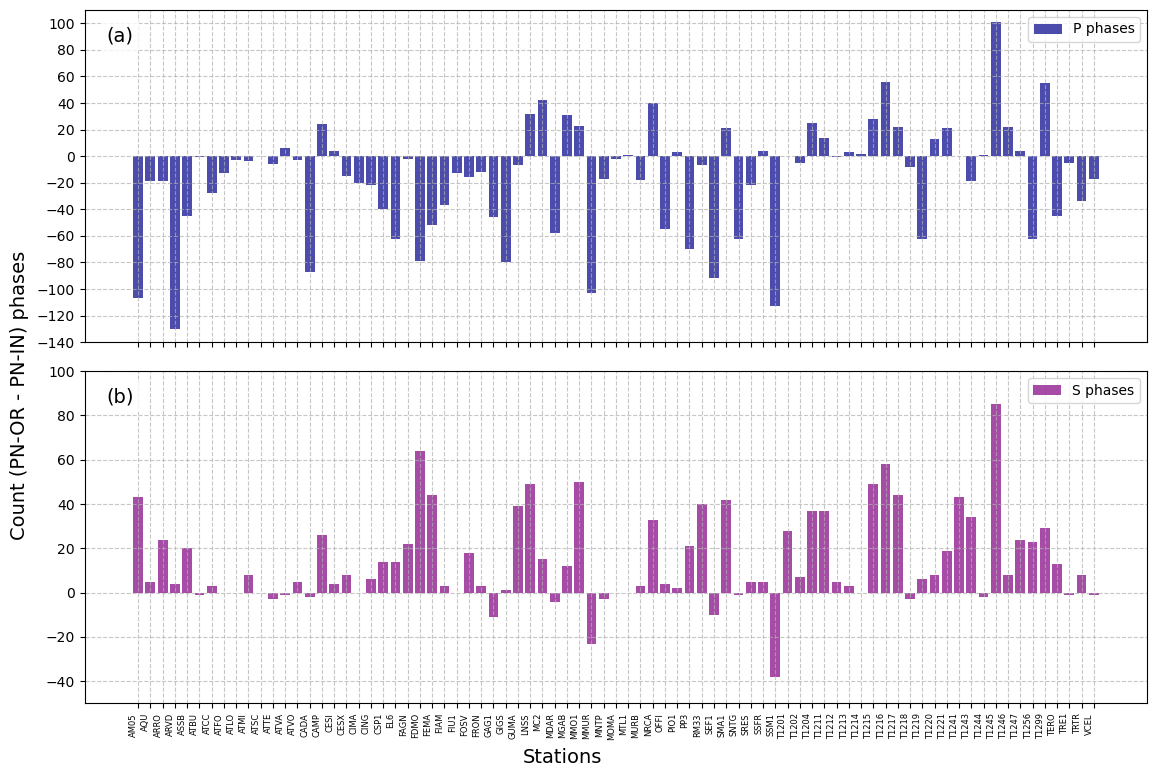

In [23]:
# OR-IN
plot_phase_difference(
    picks_data1=picks_pno, 
    picks_data2=picks_pni, 
    dataset1_label="PN-OR", 
    dataset2_label="PN-IN", 
    output_file="./FIGURE/missing_picks_OR_IN.png"
)


In [24]:
all_picks_or=find_picks(evepno, "PN_OR")

In [25]:
all_picks_in=find_picks(evepni,"PN_IN")

In [26]:
all_picks_ingv=find_ingv_picks(catINGV,"INGV")

In [27]:
station_used=all_picks_ingv['station'].unique().tolist()

In [28]:
len(station_used)

79

In [29]:
cat_a = read_events('/home/jovyan/shared/users/spina/Norcia/Norcia_2016_20240228A_coherence__Tan2021_smooth_20161020-1130_INGV/events/CATALOG_MAG/catalog.xml')


In [30]:
result_a_df = cat2df(cat_a)
result_a_df['Time_dt'] = result_a_df['Time'].apply(lambda x: x.datetime)

In [31]:
result_a_df

,ID,Time,Longitude,Latitude,Depth,Magnitude,Mag_error,rms,Time_dt
0,8587961,2016-10-20T00:16:44.955635Z,13.246604,42.937085,2.945312,1.4,0.3,0.135994,2016-10-20 00:16:44.955635
1,8588051,2016-10-20T00:38:34.884880Z,13.221202,42.832052,1.390625,0.9,0.2,0.088241,2016-10-20 00:38:34.884880
2,8588151,2016-10-20T00:54:51.743248Z,13.192131,42.739964,6.136719,3.1,0.2,0.089477,2016-10-20 00:54:51.743248
3,8588201,2016-10-20T00:56:51.338829Z,13.134566,42.759887,0.773438,2.4,0.2,0.099576,2016-10-20 00:56:51.338829
4,8588231,2016-10-20T00:58:05.853125Z,13.192131,42.739964,6.121094,1.6,0.3,0.124249,2016-10-20 00:58:05.853125
...,...,...,...,...,...,...,...,...,...
13979,10830541,2016-11-30T23:13:44.957864Z,13.163374,42.857744,3.324219,1.3,0.3,0.154013,2016-11-30 23:13:44.957864
13980,10830821,2016-11-30T23:19:51.364034Z,13.032284,42.914822,8.851562,1.4,0.3,0.171251,2016-11-30 23:19:51.364034
13981,10831131,2016-11-30T23:26:46.396281Z,13.235206,42.871444,8.621094,1.0,0.3,0.069344,2016-11-30 23:26:46.396281
13982,10831201,2016-11-30T23:28:02.586306Z,13.035155,42.838538,8.484375,1.5,0.2,0.080689,2016-11-30 23:28:02.586306


In [32]:
column_names = ['C1', 'station', 'C3', 'Lat', 'Lon','C7','elev'] 
stalista = pd.read_csv('./Norcia_2016_GTSRCE_maxradius0.8.in', sep=" ", header=None, names=column_names)

all_picks_or['event_id'] = all_picks_or['event_id'].astype(int)
all_picks_in['event_id'] = all_picks_in['event_id'].astype(int)
result_a_df['ID'] = result_a_df['ID'].astype(int)

# Esegui il merge

all_picks_or = all_picks_or.merge(
    stalista[['station', 'Lat','Lon']],  # Seleziona solo le colonne necessarie
    left_on='station',  # Colonna nel primo dataframe
    right_on='station',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)

all_picks_or = all_picks_or.merge(
    result_a_df[['ID', 'Latitude','Longitude']],  # Seleziona solo le colonne necessarie
    left_on='event_id',  # Colonna nel primo dataframe
    right_on='ID',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)
all_picks_or = add_distance_column(all_picks_or)


all_picks_in = all_picks_in.merge(
    stalista[['station', 'Lat','Lon']],  # Seleziona solo le colonne necessarie
    left_on='station',  # Colonna nel primo dataframe
    right_on='station',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)


# Esegui il merge
all_picks_in = all_picks_in.merge(
    result_a_df[['ID', 'Latitude','Longitude']],  # Seleziona solo le colonne necessarie
    left_on='event_id',  # Colonna nel primo dataframe
    right_on='ID',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)

all_picks_in = add_distance_column(all_picks_in)

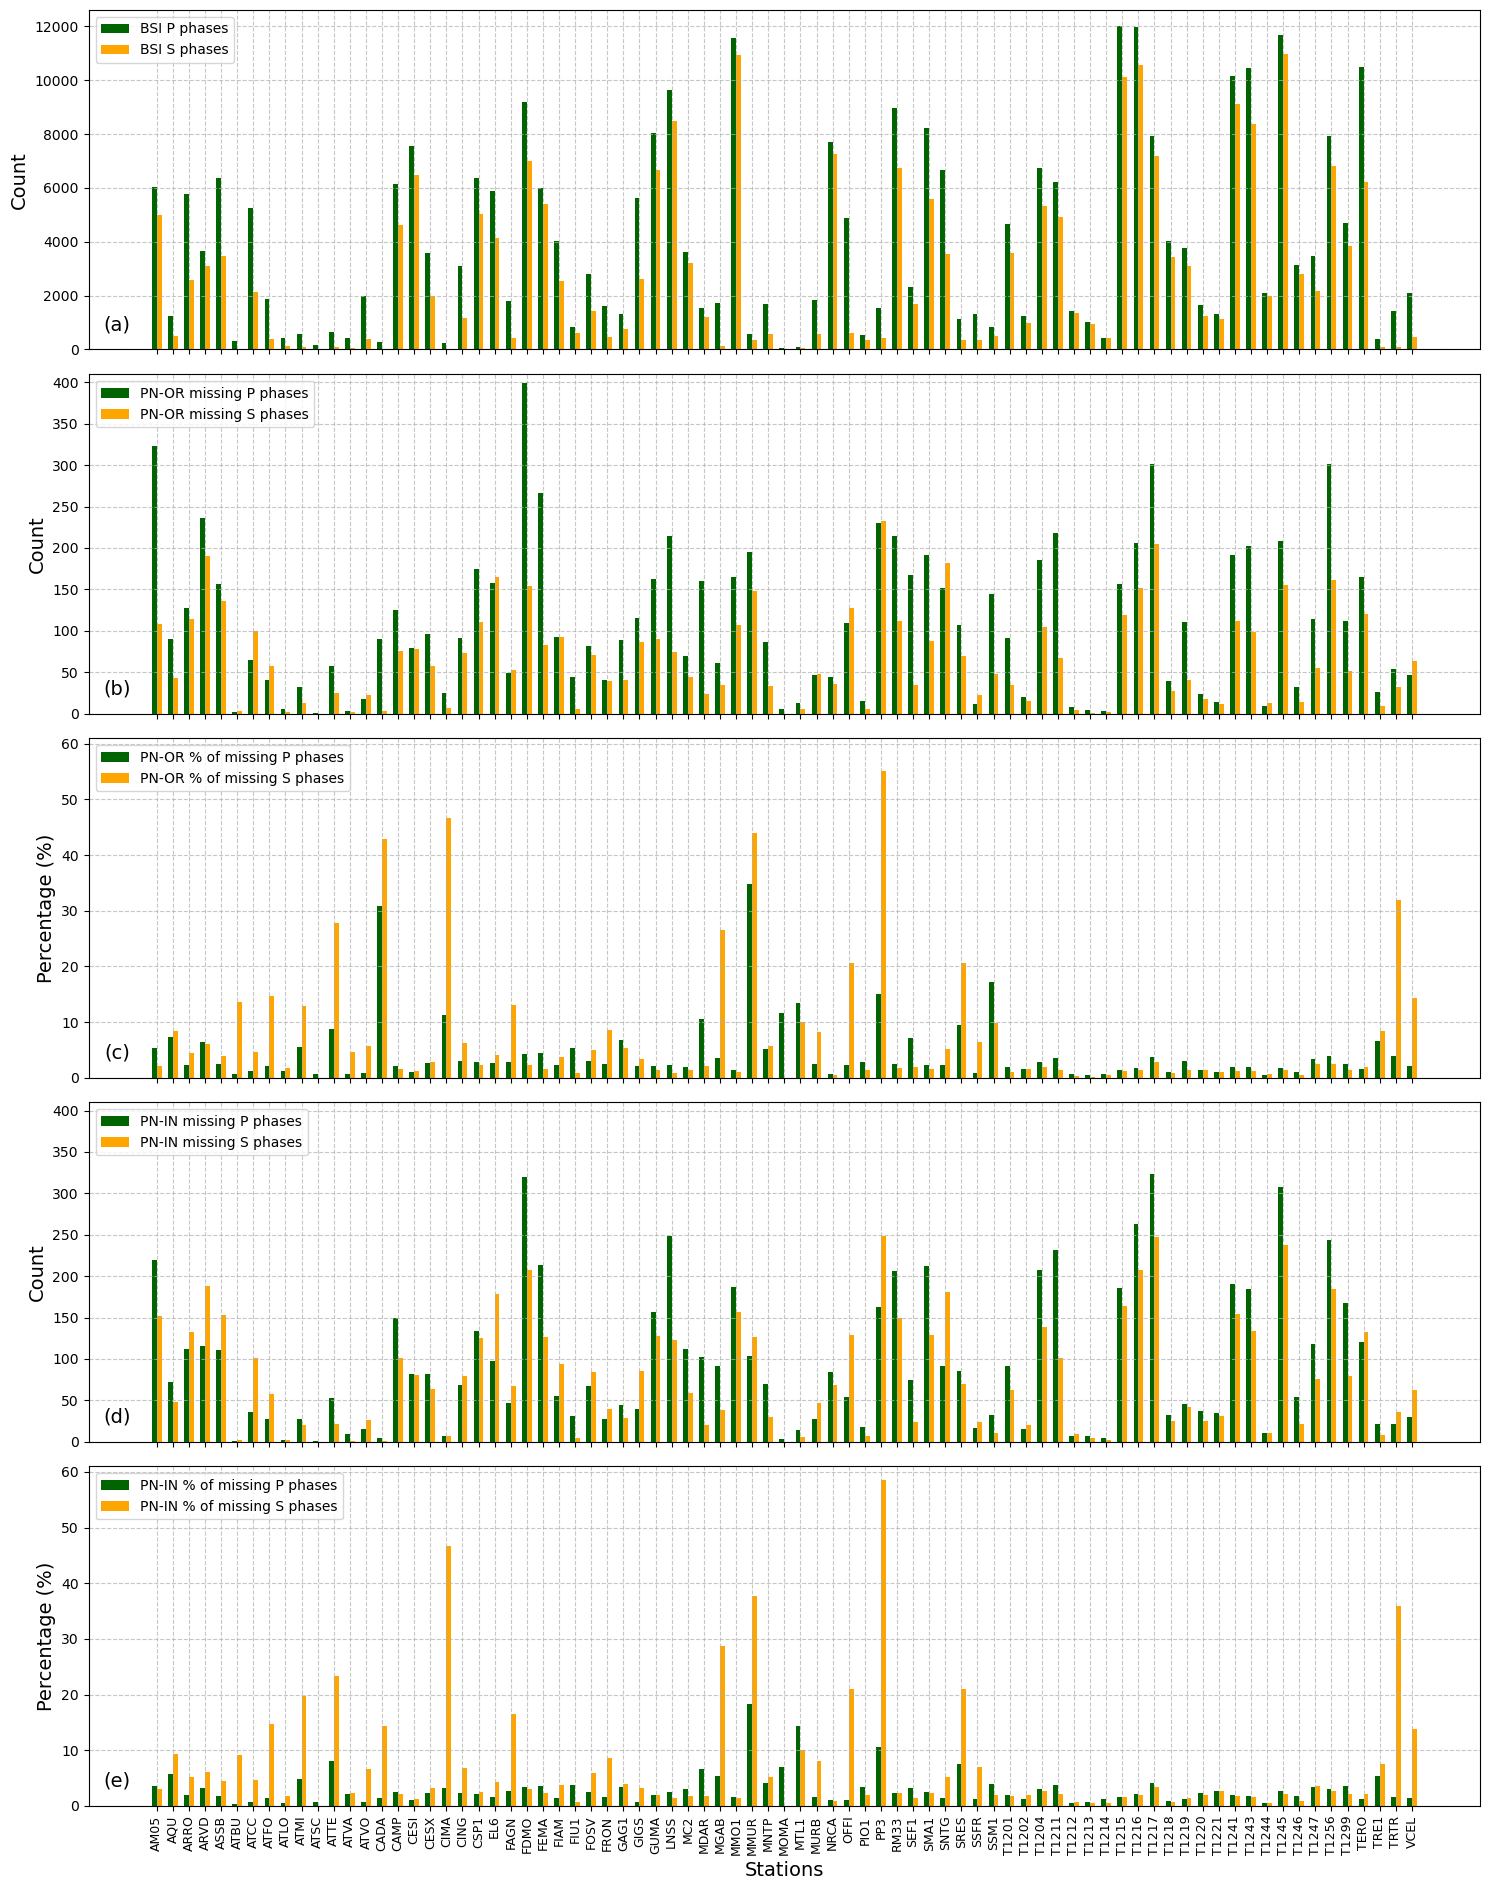

In [33]:
df_1 = pd.read_csv('./missing_combination_ORIG28_01.csv')
df_2 = pd.read_csv('./missing_combination_INSTANCE28_005.csv')

# Filtrare i dati per phase_hint "p" e "s"
df_1_p = df_1[df_1['phase_hint'] == 'P']
df_1_s = df_1[df_1['phase_hint'] == 'S']
df_2_p = df_2[df_2['phase_hint'] == 'P']
df_2_s = df_2[df_2['phase_hint'] == 'S']

all_picks_or_p = all_picks_or[all_picks_or['phase_hint'] == "P"]
all_picks_or_s = all_picks_or[all_picks_or['phase_hint'] == "S"]
all_picks_in_p = all_picks_in[all_picks_in['phase_hint'] == "P"]
all_picks_in_s = all_picks_in[all_picks_in['phase_hint'] == "S"]

all_picks_ingv_p = all_picks_ingv[all_picks_ingv['phase_hint'] == "P"]
all_picks_ingv_s = all_picks_ingv[all_picks_ingv['phase_hint'] == "S"]

# Contare le occorrenze delle stazioni per ogni phase_hint
counts_1_p = df_1_p['station'].value_counts()
counts_1_s = df_1_s['station'].value_counts()
counts_2_p = df_2_p['station'].value_counts()
counts_2_s = df_2_s['station'].value_counts()

counts_all_or_p = all_picks_or_p['station'].value_counts()
counts_all_or_s = all_picks_or_s['station'].value_counts()
counts_all_in_p = all_picks_in_p['station'].value_counts()
counts_all_in_s = all_picks_in_s['station'].value_counts()

counts_all_ingv_p = all_picks_ingv_p['station'].value_counts()
counts_all_ingv_s = all_picks_ingv_s['station'].value_counts()

# Definire la larghezza delle barre e gli offset
width = 0.3
indices = sorted(set(counts_1_p.index) | set(counts_1_s.index))
empty_string_labels = ['']*len(indices)

# Calcolo delle percentuali
percent_missing_1_p = [(counts_1_p.get(index, 0) / counts_all_ingv_p.get(index, 1)) * 100 for index in indices]
percent_missing_2_p = [(counts_2_p.get(index, 0) / counts_all_ingv_p.get(index, 1)) * 100 for index in indices]
percent_missing_1_s = [(counts_1_s.get(index, 0) / counts_all_ingv_s.get(index, 1)) * 100 for index in indices]
percent_missing_2_s = [(counts_2_s.get(index, 0) / counts_all_ingv_s.get(index, 1)) * 100 for index in indices]

x_p = range(len(indices))
x_s = range(len(indices))



# Creare i pannelli
fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=False)

# Primo pannello: P per df_1 e all_picks_or
axes[0].bar([x - 0.5 * width for x in x_p], [counts_all_ingv_p.get(index, 0) for index in indices], width, label='BSI P phases', color='darkgreen')
axes[0].bar([x + 0.5 * width for x in x_s], [counts_all_ingv_s.get(index, 0) for index in indices], width, label='BSI S phases', color='orange')
# axes[0].set_title('Picks P: Comparison between found and missing picks for PN-OR')
axes[0].set_ylabel('Count',fontsize=14)
axes[0].legend(loc='upper left')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].set_xticks(x_p)
# axes[0].set_xticklabels(indices, rotation=90, ha='center',fontsize=9)
axes[0].set_xticklabels(empty_string_labels)


# Secondo pannello: S per df_1 e all_picks_or
axes[1].bar([x - 0.5 * width for x in x_p], [counts_1_p.get(index, 0) for index in indices], width, label='PN-OR missing P phases', color='darkgreen')
axes[1].bar([x + 0.5 * width for x in x_s], [counts_1_s.get(index, 0) for index in indices], width, label='PN-OR missing S phases', color='orange')
# axes[1].set_title('Picks P: Comparison between found and missing picks for PN-OR')
axes[1].set_ylabel('Count',fontsize=14)
axes[1].legend(loc='upper left')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].set_xticks(x_p)
axes[1].set_ylim(0,410)
# axes[1].set_xticklabels(indices, rotation=90, ha='center',fontsize=9)
axes[1].set_xticklabels(empty_string_labels)


# Terzo pannello: S per df_2 e all_picks_in
axes[2].bar([x - 0.5 * width for x in x_p], percent_missing_1_p, width, label='PN-OR % of missing P phases', color='darkgreen')
axes[2].bar([x + 0.5 * width for x in x_s], percent_missing_1_s, width, label='PN-OR % of missing S phases', color='orange')
# axes[2].set_title('Picks S: Comparison between found and missing picks for PN-IN')
axes[2].set_ylabel('Percentage (%)',fontsize=14)
axes[2].legend(loc='upper left')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].grid(axis='x', linestyle='--', alpha=0.7)
axes[2].set_xticks(x_p)
axes[2].set_ylim(0,61)
# axes[2].set_xticklabels(indices, rotation=90, ha='center',fontsize=9)
axes[2].set_xticklabels(empty_string_labels)

# Terzo pannello: P per df_2 e all_picks_in
axes[3].bar([x - 0.5 * width for x in x_p], [counts_2_p.get(index, 0) for index in indices], width, label='PN-IN missing P phases', color='darkgreen')
axes[3].bar([x + 0.5 * width for x in x_s], [counts_2_s.get(index, 0) for index in indices], width, label='PN-IN missing S phases', color='orange')
# axes[3].set_title('Picks P: Comparison between found and missing picks for PN-IN')
axes[3].set_ylabel('Count',fontsize=14)
axes[3].legend(loc='upper left')
axes[3].grid(axis='y', linestyle='--', alpha=0.7)
axes[3].grid(axis='x', linestyle='--', alpha=0.7)
axes[3].set_xticks(x_p)
axes[3].set_ylim(0,410)
# axes[3].set_xticklabels(indices, rotation=90, ha='center',fontsize=9)
axes[3].set_xticklabels(empty_string_labels)

# Quinto pannello: P per df_1 e df_2
axes[4].bar([x - 0.5 * width for x in x_p], percent_missing_2_p, width, label='PN-IN % of missing P phases', color='darkgreen')
axes[4].bar([x + 0.5 * width for x in x_s], percent_missing_2_s, width, label='PN-IN % of missing S phases', color='orange')
# axes[4].set_title('Picks P: Percentage of Missing Picks')
axes[4].set_xlabel('Stations',fontsize=14)
axes[4].set_ylabel('Percentage (%)', fontsize=14)
axes[4].legend(loc='upper left')
axes[4].grid(axis='y', linestyle='--', alpha=0.7)
axes[4].grid(axis='x', linestyle='--', alpha=0.7)
axes[4].set_xticks(x_p)
axes[4].set_ylim(0,61)
axes[4].set_xticklabels(indices, rotation=90, ha='center', fontsize=9)




axes[0].text(0.03, 0.1, '(a)',
                transform=axes[0].transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right', backgroundcolor='white')
axes[1].text(0.03, 0.1, '(b)',
                transform=axes[1].transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right', backgroundcolor='white')
axes[2].text(0.03, 0.1, '(c)',
                transform=axes[2].transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right', backgroundcolor='white')
axes[3].text(0.03, 0.1, '(d)',
                transform=axes[3].transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right', backgroundcolor='white')
axes[4].text(0.03, 0.1, '(e)',
                 transform=axes[4].transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right', backgroundcolor='white')



# Mostrare il grafico
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("./FIGURE/found_and_missing_picks.png",dpi=300)
plt.show()


In [34]:
df_1 = pd.read_csv('./missing_combination_ORIG28_01.csv')

df_1.sort_values(by='event_id',inplace=True)
df_no_duplicates_o = df_1.assign(diff = df_1['expected'] - df_1['found'])
df_no_duplicates_o['phase_hint'] = df_no_duplicates_o['phase_hint'].str[0]
print('Number of unique events = ',len(df_1['event_id'].unique()))

Number of unique events =  6529


In [35]:
df_1 = pd.read_csv('./missing_combination_INSTANCE28_005.csv')

df_1.sort_values(by='event_id',inplace=True)
df_no_duplicates_i = df_1.assign(diff = df_1['expected'] - df_1['found'])
df_no_duplicates_i['phase_hint'] = df_no_duplicates_i['phase_hint'].str[0]
print('Number of unique events = ',len(df_1['event_id'].unique()))

Number of unique events =  5744


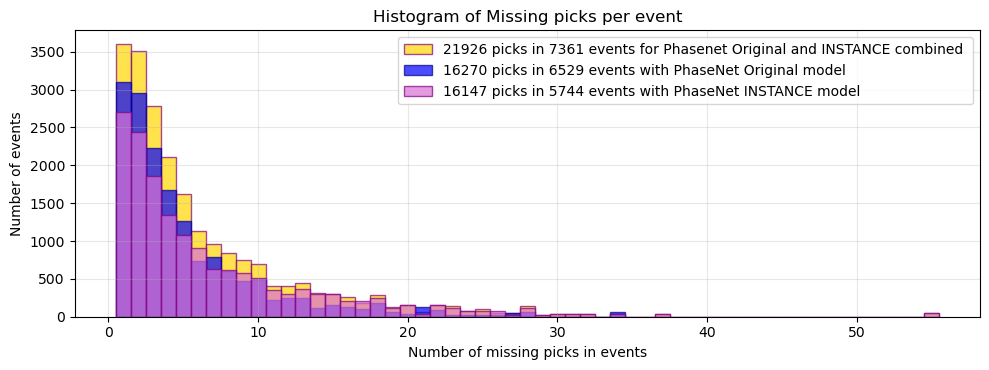

In [36]:

plt.figure(figsize=(10, 4))

# # Set a fixed bin size of 1
# bin_size = 1
# bin_edges_o = np.arange(df_no_duplicates_o['diff'].min(), df_no_duplicates_o['diff'].max() + bin_size, bin_size)
# bin_edges_i = np.arange(df_no_duplicates_i['diff'].min(), df_no_duplicates_i['diff'].max() + bin_size, bin_size)

bin_size = 1
# Calcola i bordi spostati di -0.5 e +0.5
bin_edges_o = np.arange(df_no_duplicates_o['diff'].min() - 0.5, df_no_duplicates_o['diff'].max() + 1, bin_size)
bin_edges_i = np.arange(df_no_duplicates_i['diff'].min() - 0.5, df_no_duplicates_i['diff'].max() + 1, bin_size)


plt.grid(alpha=0.3)
plt.hist(df_no_duplicates_all['diff'], bins=bin_edges_i, color='gold',alpha=0.7,edgecolor='purple',
         label=f"{len(df_no_duplicates_all)} picks in {len(df_no_duplicates_all['event_id'].unique())} events for Phasenet Original and INSTANCE combined ")
plt.hist(df_no_duplicates_o['diff'], bins=bin_edges_o, color='blue',alpha=0.7,edgecolor='darkblue',
         label=f"{len(df_no_duplicates_o)} picks in {len(df_no_duplicates_o['event_id'].unique())} events with PhaseNet Original model")
plt.hist(df_no_duplicates_i['diff'], bins=bin_edges_i, color='orchid',alpha=0.7,edgecolor='purple',
         label=f"{len(df_no_duplicates_i)} picks in {len(df_no_duplicates_i['event_id'].unique())} events with PhaseNet INSTANCE model")


plt.legend()
plt.xlabel('Number of missing picks in events')
plt.ylabel('Number of events')
plt.title('Histogram of Missing picks per event')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./FIGURE/Number_missing_picks_per_event.png')
plt.show()


In [37]:
# Assicurati che 'ID' sia convertito in intero
result_a_df['ID'] = result_a_df['ID'].astype(int)

# Esegui il merge
df_no_duplicates_i = df_no_duplicates_i.merge(
    result_a_df[['ID', 'Magnitude']],  # Seleziona solo le colonne necessarie
    left_on='event_id',  # Colonna nel primo dataframe
    right_on='ID',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)

# # Rimuovi la colonna ID (opzionale, se non necessaria)
# df_no_duplicates_i.drop(columns=['ID_x'], inplace=True)
# df_no_duplicates_i.drop(columns=['ID_y'], inplace=True)


df_no_duplicates_o = df_no_duplicates_o.merge(
    result_a_df[['ID', 'Magnitude']],  # Seleziona solo le colonne necessarie
    left_on='event_id',  # Colonna nel primo dataframe
    right_on='ID',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)

# # Rimuovi la colonna ID (opzionale, se non necessaria)
# df_no_duplicates_o.drop(columns=['ID_x'], inplace=True)
# df_no_duplicates_o.drop(columns=['ID_y'], inplace=True)


# Stampa o verifica il risultato (opzionale)
# print(df_no_duplicates_i.head())





In [38]:
df_no_duplicates_i['event_id'] = df_no_duplicates_i['event_id'].astype(int)
df_no_duplicates_i = df_no_duplicates_i.merge(
    stalista[['station', 'Lat','Lon']],  # Seleziona solo le colonne necessarie
    left_on='station',  # Colonna nel primo dataframe
    right_on='station',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)


# Esegui il merge
df_no_duplicates_i = df_no_duplicates_i.merge(
    result_a_df[['ID', 'Latitude','Longitude']],  # Seleziona solo le colonne necessarie
    left_on='event_id',  # Colonna nel primo dataframe
    right_on='ID',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)
df_no_duplicates_i = add_distance_column(df_no_duplicates_i)

In [39]:
df_no_duplicates_o['event_id'] = df_no_duplicates_o['event_id'].astype(int)
df_no_duplicates_o = df_no_duplicates_o.merge(
    stalista[['station', 'Lat','Lon']],  # Seleziona solo le colonne necessarie
    left_on='station',  # Colonna nel primo dataframe
    right_on='station',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)


# Esegui il merge
df_no_duplicates_o = df_no_duplicates_o.merge(
    result_a_df[['ID', 'Latitude','Longitude']],  # Seleziona solo le colonne necessarie
    left_on='event_id',  # Colonna nel primo dataframe
    right_on='ID',       # Colonna nel secondo dataframe
    how='left'           # Mantieni tutti i record di df_no_duplicates_i
)
df_no_duplicates_o = add_distance_column(df_no_duplicates_o)

In [40]:
df_no_duplicates_o_p = df_no_duplicates_o[df_no_duplicates_o['phase_hint'] == 'P']
df_no_duplicates_o_s = df_no_duplicates_o[df_no_duplicates_o['phase_hint'] == 'S']
df_no_duplicates_i_p = df_no_duplicates_i[df_no_duplicates_i['phase_hint'] == 'P']
df_no_duplicates_i_s = df_no_duplicates_i[df_no_duplicates_i['phase_hint'] == 'S']


In [43]:
all_picks_or_p = all_picks_or[all_picks_or['phase_hint'] == "P"]
all_picks_or_s = all_picks_or[all_picks_or['phase_hint'] == "S"]
all_picks_in_p = all_picks_in[all_picks_in['phase_hint'] == "P"]
all_picks_in_s = all_picks_in[all_picks_in['phase_hint'] == "S"]

all_picks_ingv_p = all_picks_ingv[all_picks_ingv['phase_hint'] == "P"]
all_picks_ingv_s = all_picks_ingv[all_picks_ingv['phase_hint'] == "S"]


In [44]:


# Assicurati che ID sia intero
result_a_df['ID'] = result_a_df['ID'].astype(int)

# Lista dei dataframe da aggiornare
dataframes = [all_picks_or_p, all_picks_or_s, all_picks_in_p, all_picks_in_s]
new_dataframes = []

for df in dataframes:
    df = df.copy()  # Evita SettingWithCopyWarning
    df['event_id'] = df['event_id'].astype(int)

    # Se 'ID' già esiste, lo droppiamo prima del merge
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])

    df = df.merge(
        result_a_df[['ID', 'Magnitude']],
        left_on='event_id',
        right_on='ID',
        how='left'
    )

    new_dataframes.append(df)

# Riassegna i dataframe se ti servono con i nomi originali
all_picks_or_p, all_picks_or_s, all_picks_in_p, all_picks_in_s = new_dataframes


/tmp/ipykernel_7787/1777769183.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Riserva spazio a destra per le colorbar


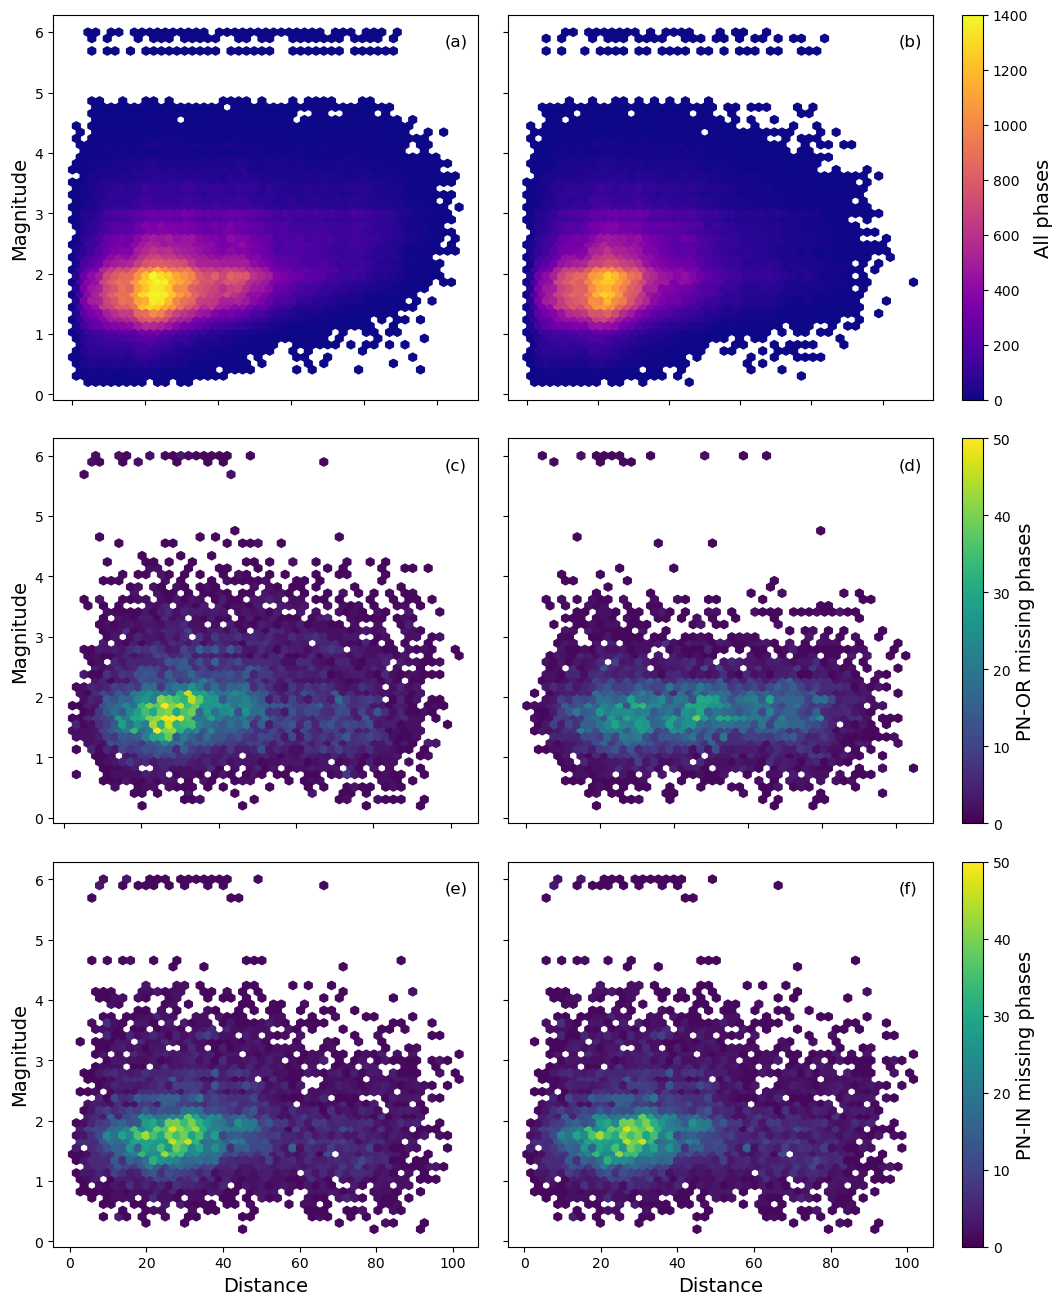

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Configura la figura e i subplot
fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.1, hspace=0.1)

# Lista dei DataFrame e titoli corrispondenti
dataframes = [
    ('all_picks_or_p', 'all_picks_or_s'),
    ('df_no_duplicates_o_p', 'df_no_duplicates_o_s'),
    ('df_no_duplicates_i_p', 'df_no_duplicates_i_p')
]

titles = [
    ('P phases', 'S phases'),
    ('Missing P phases', 'Missing S phases'),
    ('Missing P phases', 'Missing S phases')
]

colorlabs = [
    'All phases',
    'PN-OR missing phases',
    'PN-IN missing phases'
]

# Genera una lista di etichette per i pannelli
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Itera attraverso i dataframe, i titoli e gli assi per plottare i grafici
for row_idx, ((df1_name, df2_name), (title1, title2)) in enumerate(zip(dataframes, titles)):
    for col_idx, (df_name, title) in enumerate(zip([df1_name, df2_name], [title1, title2])):
        # Seleziona l'asse corrente
        ax = fig.add_subplot(gs[row_idx, col_idx])
        
        # Ottieni il DataFrame in base al nome
        df = globals()[df_name]  # Recupera il DataFrame dalla variabile globale
        
        # Parametri per il grafico hexbin
        x = df['distance']
        y = df['Magnitude']
        
        # Imposta i limiti della colorbar in base alla riga
        if row_idx == 0:
            vmin, vmax = 0, 1400
        else:
            vmin, vmax = 0, 50
        
        # hb = ax.hexbin(x, y, gridsize=50, cmap='viridis', mincnt=1, vmin=vmin, vmax=vmax)
        if row_idx == 0:
            cmap = 'plasma'  # Prima riga con plasma
        else:
            cmap = 'viridis'  # Dopo viridis
        hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, mincnt=1, vmin=vmin, vmax=vmax)
        
        # Aggiungi la label del pannello
        label_idx = row_idx * 2 + col_idx  # Calcola l'indice della label
        ax.text(0.92, 0.95, panel_labels[label_idx], transform=ax.transAxes,
                fontsize=12, va='top', ha='left')
        
        # Mostra etichette e numeri degli assi solo per i pannelli richiesti
        if row_idx < 2:  # Nasconde i numeri sull'asse x se non è l'ultima riga
            ax.set_xticklabels([])
        else:  # Mostra etichetta 'Distance' solo nell'ultima riga
            ax.set_xlabel('Distance',fontsize=14)
        
        if col_idx > 0:  # Nasconde i numeri sull'asse y se non è la prima colonna
            ax.set_yticklabels([])
        else:  # Mostra etichetta 'Magnitude' solo nella prima colonna
            ax.set_ylabel('Magnitude',fontsize=14)

    # Aggiungi una colorbar comune per ogni riga
    cax = fig.add_subplot(gs[row_idx, 2])  # Assegna la colonna dedicata alla colorbar
    cb = fig.colorbar(hb, cax=cax, orientation='vertical')
    cb.set_label(colorlabs[row_idx],fontsize=14)  # Imposta la label della colorbar

# Personalizza la disposizione dei pannelli
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Riserva spazio a destra per le colorbar
# plt.savefig('FIGURE/hexbin_magnitude_distance.png', dpi=300)

plt.show()
